In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

Pre-pare dataset

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 64

all_class = ['normal', 'bacteria', 'virus']
# 'normal':0, 'bacteria': 1, 'virus':2
class_map = {cls:i for i,cls in enumerate(all_class)}
class_map

{'bacteria': 1, 'normal': 0, 'virus': 2}

In [ ]:
# read all paths
path = '/content/drive/MyDrive/'
img_paths_all = glob(path+'pneumonia-kaggle/train/*/*.jpeg')
img_paths_test = sorted(glob(path+'pneumonia-kaggle/test/*.jpeg'))

img_paths_train, img_paths_val = train_test_split(img_paths_all, test_size=0.2)

In [ ]:
# number of images
len(img_paths_train), len(img_paths_val), len(img_paths_test)

(4172, 1044, 624)

/content/drive/MyDrive/pneumonia-kaggle/train/PNEUMONIA/person276_bacteria_1296.jpeg
(256, 256, 3)


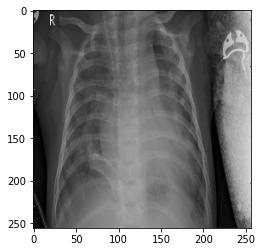

In [ ]:
path = np.random.choice(img_paths_train)
print(path)

img = cv2.imread(path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
print(img.shape)
plt.imshow(img)
plt.show()

In [ ]:
# read image label

cls = path.split(os.sep)[-2].lower()
if cls == 'pneumonia':
    # get filename
    filename = path.split(os.sep)[-1]
    # get pneumonia subclass
    cls = filename.split('_')[1] 
    cls_idx = class_map[cls]
# for normal class
else:
    cls_idx = class_map['normal']

print('Class name:', cls)
print('Class idx: ', cls_idx)

Class name: bacteria
Class idx:  1


In [ ]:
classes = []
for path in img_paths_train :
  cls = path.split(os.sep)[-2].lower()
  if cls == 'pneumonia':
      # get filename
      filename = path.split(os.sep)[-1]
      # get pneumonia subclass
      cls = filename.split('_')[1] 
      cls_idx = class_map[cls]
  # for normal class
  else:
      cls_idx = class_map['normal']  
  classes.append(cls_idx)

<BarContainer object of 3 artists>

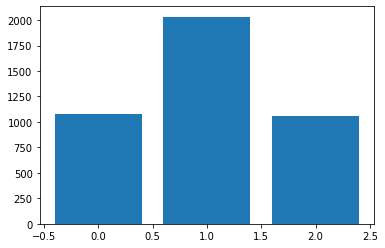

In [ ]:
# Class distribution
cls, count = np.unique(classes, return_counts=True)
plt.bar(cls, count)

In [ ]:
class DataGenerator(utils.Sequence):
    def __init__(self, paths, batch_size, img_size, mode='train'):
        self.paths = paths
        self.batch_size = batch_size
        self.mode = mode
        self.img_size = img_size

        self.shuffle = mode == 'train'
        self.indexes = np.arange(len(self.paths)) # [0, 1, 2, ..., len(self.paths)]
        self.all_class = ['normal', 'bacteria', 'virus']
        self.class_map = {cls:i for i,cls in enumerate(all_class)}
        self.num_classes = len(self.class_map)
        self.on_epoch_end()

    def __len__(self):
        'number of batches per epoch'
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        idxs = self.indexes[index*self.batch_size: (index + 1)*self.batch_size]
        # Find list of IDs
        batch_paths = [self.paths[i] for i in idxs]
        # Generate data
        return self.__data_generation(batch_paths)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, paths):
        """
        Generates data containing batch_size samples
        """
        x = np.empty((len(paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(paths)))

        for i, path in enumerate(paths):
            img = cv2.imread(path)[:, :, ::-1]
            # img preprocess
            img = cv2.resize(img, (self.img_size, self.img_size))

            # TODO: Data Augmentation
            # img = self.aug.augment_image(img)

            # Preprocess
            img = img / 255.
            # img = tf.keras.applications.efficientnet.preprocess_input(img)

            if self.mode != 'test':
                # read class label
                cls = path.split(os.sep)[-2].lower()
                if cls == 'pneumonia':
                    # get filename
                    filename = path.split(os.sep)[-1]
                    # get pneumonia subclass
                    cls_pneumonia = filename.split('_')[1] 
                    cls_idx = class_map[cls_pneumonia]
                # for normal class
                else:
                    cls_idx = class_map[cls]
                y[i] = cls_idx
            x[i] = img

        if self.mode != 'test':            
            # one-hot encoding
            y = tf.keras.utils.to_categorical(y, num_classes=self.num_classes)
            return x, y
        else:
            return x

In [ ]:
gen_train = DataGenerator(img_paths_train, BATCH_SIZE, IMG_SIZE, mode='train')
gen_val = DataGenerator(img_paths_val, BATCH_SIZE, IMG_SIZE, mode='val')
gen_test = DataGenerator(img_paths_test, BATCH_SIZE, IMG_SIZE, mode='test')

In [ ]:
gen_train.indexes

array([3477,  969, 3792, ..., 3410, 1484,  765])

In [ ]:
# def __len__(): batches per opech
len(gen_train), len(gen_val)

(66, 17)

In [ ]:
# get 1 batch
# def __getitem__(self, batch_idx)
imgs, labels = gen_train[0]

In [ ]:
imgs.shape, labels.shape

((64, 256, 256, 3), (64, 3))

In [ ]:
for i in range(len(imgs)):
    label = labels[i]
    class_idx = np.argmax(label)
    print('label: ', label)
    print('class idx:', class_idx)
    print('class name: ', all_class[class_idx])
    plt.imshow(imgs[i])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
img_rows,img_cols = 256,256
RGB = 3
num_classes = 3

In [ ]:
# # Build your own model
from tensorflow.keras.layers import Input # Input Layer
from tensorflow.keras.applications import VGG16 # Keras Application
from tensorflow.keras.layers import Dense # Dense Layer (Fully connected)
from tensorflow.keras.models import Model # Model Structure



input_shape = (img_rows,img_cols,RGB)

img_input = Input(shape=input_shape)
base_model = VGG16(include_top=False, 
        input_tensor=img_input, 
        input_shape=input_shape, 
        pooling="max", 
        weights='imagenet')
base_model.trainable = False
x = base_model.output
predictions = Dense(num_classes, 
        activation="softmax", 
        name="predictions")(x)
model = Model(inputs=img_input, 
              outputs=predictions)
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #by default learning_rate=0.001
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy"),tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.Precision(name='precision')]
)

In [ ]:
Batch_size = 64
Epochs = 50
ImageDataGenerator_threshold = False

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Pneumonia_model.hdf5', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1) # val_categorical_accuracy f1
callbacks_list =  [checkpoint]

In [ ]:
logs = model.fit(gen_train,validation_data=gen_val,epochs=Epochs)

Epoch 1/50
66/66 [==============================] - 200s 3s/step - loss: 1.2628 - categorical_accuracy: 0.2967 - auc: 0.4393 - recall: 0.1026 - precision: 0.2534 - val_loss: 1.0972 - val_categorical_accuracy: 0.4444 - val_auc: 0.5825 - val_recall: 0.1197 - val_precision: 0.4085
Epoch 2/50
66/66 [==============================] - 179s 3s/step - loss: 1.0682 - categorical_accuracy: 0.4684 - auc: 0.6162 - recall: 0.1740 - precision: 0.4504 - val_loss: 1.0482 - val_categorical_accuracy: 0.4847 - val_auc: 0.6391 - val_recall: 0.1954 - val_precision: 0.5087
Epoch 3/50
66/66 [==============================] - 179s 3s/step - loss: 1.0206 - categorical_accuracy: 0.5007 - auc: 0.6688 - recall: 0.2169 - precision: 0.5400 - val_loss: 1.0032 - val_categorical_accuracy: 0.5115 - val_auc: 0.6886 - val_recall: 0.2471 - val_precision: 0.5683
Epoch 4/50
66/66 [==============================] - 183s 3s/step - loss: 0.9792 - categorical_accuracy: 0.5312 - auc: 0.7125 - recall: 0.2675 - precision: 0.6065 -

In [ ]:
# Prediction
predictions = model.predict(gen_test)

In [ ]:
class_names = ['normal', 'bacteria', 'virus']
cls_map = {cls: i for i, cls in enumerate(class_names)}
print(cls_map)

{'normal': 0, 'bacteria': 1, 'virus': 2}
